# **1. Khai báo thư viện & Tải Dữ liệu (Setup)**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import os

# Sklearn cho việc chia dữ liệu
from sklearn.model_selection import train_test_split

# Tensorflow/Keras cho mô hình Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Thiết lập seed để kết quả giống nhau mỗi lần chạy (Reproducibility)
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Đã import xong thư viện!")

✅ Đã import xong thư viện!


In [3]:
# Tên file dữ liệu của bạn
FILE_NAME = 'FC_plus_RES_withPredictions.csv'

def load_data(filepath):
    if not os.path.exists(filepath):
        print(f"❌ LỖI: Không tìm thấy file '{filepath}'. Hãy upload file lên Colab trước!")
        return None, None

    print(f"✅ Đang đọc file '{filepath}'...")
    df = pd.read_csv(filepath)

    # 1. Xử lý Input (Sequence)
    # Cắt chuỗi 30mer lấy 23 ký tự quan trọng (từ vị trí 4 đến 27)
    # Cấu trúc: 4bp đầu + [23bp LÕI] + 3bp đuôi
    sequences = df['30mer'].apply(lambda x: x[4:27]).tolist()

    # 2. Xử lý Output (Target)
    # Cột 'score_drug_gene_rank' là điểm hiệu quả thực tế (đã chuẩn hóa 0-1)
    targets = df['score_drug_gene_rank'].values

    print(f"-> Tổng số mẫu: {len(sequences)}")
    return sequences, targets

# Chạy hàm load data
raw_sequences, raw_targets = load_data(FILE_NAME)

✅ Đang đọc file 'FC_plus_RES_withPredictions.csv'...
-> Tổng số mẫu: 5310


# **2: Tiền xử lý (Preprocessing)**
Biến đổi chuỗi DNA (A, C, G, T) thành ma trận số (One-Hot Encoding) và chia tập Train/Test.

In [4]:
# --- BLOCK 2: TIỀN XỬ LÝ (ONE-HOT ENCODING) ---

def one_hot_encode(seq_list):
    print("🔄 Đang mã hóa dữ liệu...")
    # Bản đồ chuyển ký tự thành vector
    mapping = {
        'A': [1, 0, 0, 0],
        'C': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'T': [0, 0, 0, 1],
        'N': [0, 0, 0, 0] # Xử lý nhiễu nếu có
    }

    encoded_data = []
    for seq in seq_list:
        # Chỉ lấy chuỗi đúng độ dài 23
        if len(seq) == 23:
            vec = [mapping.get(base, [0,0,0,0]) for base in seq]
            encoded_data.append(vec)

    return np.array(encoded_data)

if raw_sequences is not None:
    # 1. Mã hóa
    X = one_hot_encode(raw_sequences)
    y = raw_targets

    # 2. Chia tập dữ liệu (80% Train, 10% Val, 10% Test)
    # Bước 1: Tách 20% ra làm Temp (để sau này chia đôi thành Val/Test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

    # Bước 2: Tách Temp thành Val (10%) và Test (10%)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    print("\n📊 KẾT QUẢ CHIA TẬP:")
    print(f"   - Input Shape: {X.shape}")
    print(f"   - Train set: {len(X_train)} mẫu")
    print(f"   - Val set:   {len(X_val)} mẫu")
    print(f"   - Test set:  {len(X_test)} mẫu")

🔄 Đang mã hóa dữ liệu...

📊 KẾT QUẢ CHIA TẬP:
   - Input Shape: (5310, 23, 4)
   - Train set: 4248 mẫu
   - Val set:   531 mẫu
   - Test set:  531 mẫu


## **3: EDA**

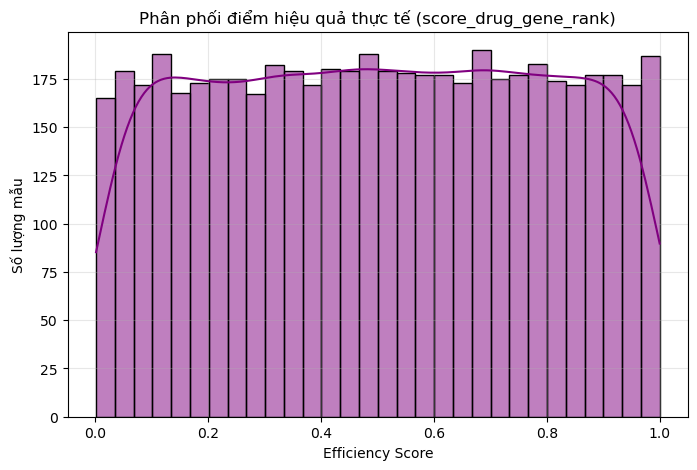

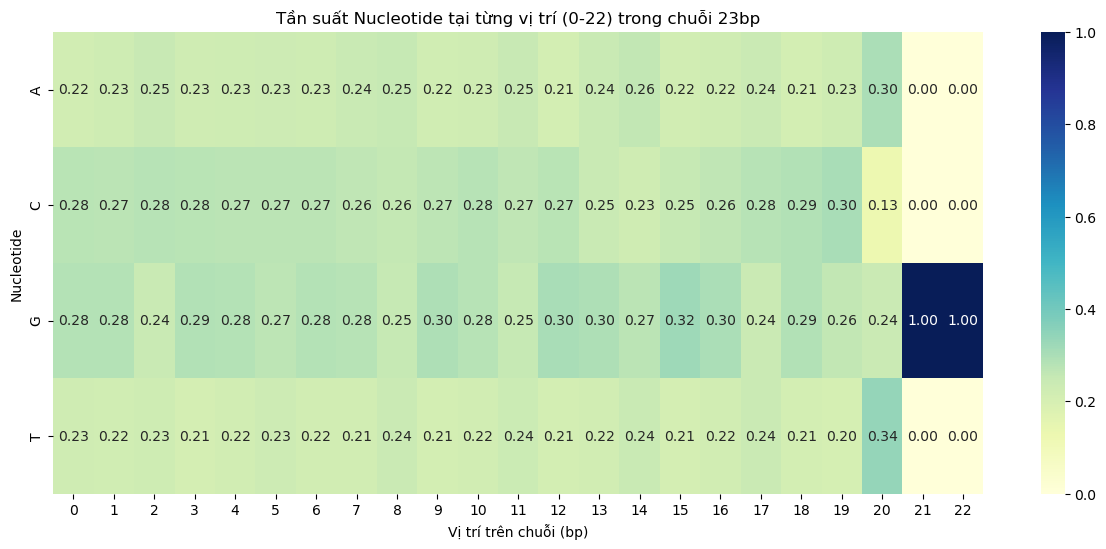

In [5]:
import seaborn as sns

# ==============================================================================
# EDA 1: Phân phối điểm hiệu quả (Target Distribution)
# ==============================================================================
plt.figure(figsize=(8, 5))
sns.histplot(raw_targets, bins=30, kde=True, color='purple')
plt.title('Phân phối điểm hiệu quả thực tế (score_drug_gene_rank)')
plt.xlabel('Efficiency Score')
plt.ylabel('Số lượng mẫu')
plt.grid(True, alpha=0.3)
plt.show()

# ==============================================================================
# EDA 2: Phân tích tần suất Nucleotide tại mỗi vị trí (Position Weight Matrix)
# ==============================================================================
def plot_nucleotide_frequency(sequences):
    # Chuyển list chuỗi thành ma trận ký tự
    seq_matrix = np.array([list(s) for s in sequences if len(s) == 23])
    
    pos_freq = []
    for i in range(23):
        col = seq_matrix[:, i]
        counts = pd.Series(col).value_counts(normalize=True)
        pos_freq.append([counts.get(b, 0) for b in ['A', 'C', 'G', 'T']])
    
    df_freq = pd.DataFrame(pos_freq, columns=['A', 'C', 'G', 'T'])
    
    plt.figure(figsize=(15, 6))
    sns.heatmap(df_freq.T, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title('Tần suất Nucleotide tại từng vị trí (0-22) trong chuỗi 23bp')
    plt.xlabel('Vị trí trên chuỗi (bp)')
    plt.ylabel('Nucleotide')
    plt.show()

plot_nucleotide_frequency(raw_sequences)

# **4: Xây dựng & Huấn luyện Model (Training)**
Đây là phần quan trọng nhất: Model Hybrid CNN-LSTM

In [6]:
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# --- BLOCK 3: MODEL CNN-LSTM ---

def build_final_model():
    inputs = Input(shape=(23, 4))

    # --- NHÁNH 1: Quét chi tiết (Kernel 3) ---
    b1 = Conv1D(64, kernel_size=3, padding='same', activation='relu')(inputs)
    b1 = BatchNormalization()(b1)

    # --- NHÁNH 2: Quét trung bình (Kernel 5) ---
    b2 = Conv1D(64, kernel_size=5, padding='same', activation='relu')(inputs)
    b2 = BatchNormalization()(b2)

    # --- NHÁNH 3: Quét rộng (Kernel 7) - MỚI THÊM VÀO ---
    b3 = Conv1D(64, kernel_size=7, padding='same', activation='relu')(inputs)
    b3 = BatchNormalization()(b3)

    # Ghép 3 nhánh
    merged = Concatenate()([b1, b2, b3])
    merged = Dropout(0.3)(merged)

    # LSTM để học ngữ cảnh
    lstm = Bidirectional(LSTM(128, return_sequences=True))(merged)
    lstm = Dropout(0.3)(lstm)

    # Attention đơn giản (Global Average Pooling)
    pooled = GlobalAveragePooling1D()(lstm)

    # Output
    dense = Dense(128, activation='relu')(pooled)
    dense = Dropout(0.4)(dense)
    outputs = Dense(1, activation='sigmoid')(dense)

    # Compile
    model = Model(inputs=inputs, outputs=outputs)
    # Giảm Learning Rate xuống thấp hơn chút nữa để học kỹ
    model.compile(optimizer=Adam(learning_rate=0.0003), loss='mse', metrics=['mae'])

    return model

# 1. Khởi tạo model mới
model = build_final_model()
model.summary()

# 2. Thiết lập Callbacks (Tự động lưu model tốt nhất)
checkpoint = ModelCheckpoint(
    'best_model.keras',       # Tên file sẽ lưu
    monitor='val_loss',       # Canh chừng val_loss
    save_best_only=True,      # Chỉ lưu khi tìm được model tốt hơn
    mode='min',               # Loss càng nhỏ càng tốt
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,              # Dừng nếu 15 epoch liên tiếp không khá hơn
    restore_best_weights=True
)

# 3. Bắt đầu Train
print("\n🚀 BẮT ĐẦU HUẤN LUYỆN...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,               # Số vòng tối đa
    batch_size=16,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)
print("\n✅ Huấn luyện hoàn tất! Model tốt nhất đã lưu tại 'best_model.keras'")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 23, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 23, 64)    │        832 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 23, 64)    │      1,344 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 23, 64)    │      1,856 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 23, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 23, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 23, 64)    │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 23, 192)   │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 23, 192)   │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 23, 256)   │    328,704 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 23, 256)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ dropout_1[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 366,529 (1.40 MB)

 Trainable params: 366,145 (1.40 MB)

 Non-trainable params: 384 (1.50 KB)


🚀 BẮT ĐẦU HUẤN LUYỆN...
Epoch 1/100
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0781 - mae: 0.2393
Epoch 1: val_loss improved from inf to 0.07687, saving model to best_model.keras
266/266 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 0.0780 - mae: 0.2393 - val_loss: 0.0769 - val_mae: 0.2426
Epoch 2/100
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0702 - mae: 0.2228
Epoch 2: val_loss improved from 0.07687 to 0.07308, saving model to best_model.keras
266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.0701 - mae: 0.2228 - val_loss: 0.0731 - val_mae: 0.2256
Epoch 3/100
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0652 - mae: 0.2131
Epoch 3: val_loss improved from 0.07308 to 0.07169, saving model to best_model.keras
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0652 - mae: 0.2131 - val_loss: 0.0717 - val_mae: 0.2214
Epoch 4/100
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0624 - mae: 0.2077
Epoch 4: val_loss improved from 0.07169 to 0.06965, saving model to

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
--------------------------------------------------
🎯 KẾT QUẢ TRÊN TẬP TEST:
   Spearman Correlation: 0.6623
--------------------------------------------------


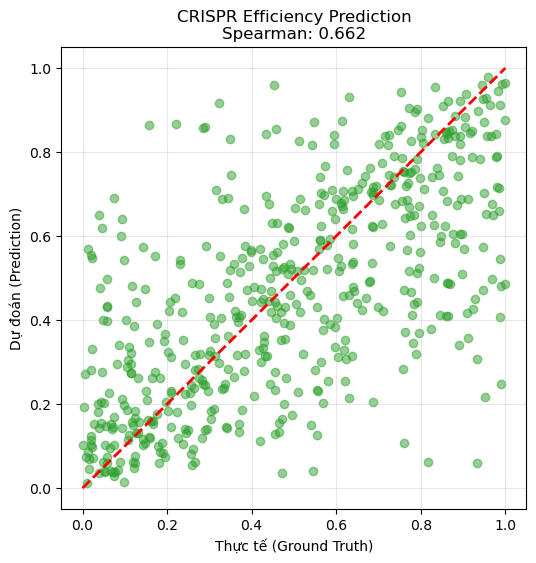

In [7]:
# --- BLOCK 4: ĐÁNH GIÁ KẾT QUẢ ---

# 1. Load lại model tốt nhất (để chắc chắn không dùng model ở epoch cuối cùng bị overfit)
final_model = load_model('best_model.keras')

# 2. Dự đoán trên tập Test (Dữ liệu model chưa từng thấy)
y_pred = final_model.predict(X_test).flatten()

# 3. Tính độ tương quan Spearman
spearman_corr, _ = spearmanr(y_test, y_pred)

print("--------------------------------------------------")
print(f"🎯 KẾT QUẢ TRÊN TẬP TEST:")
print(f"   Spearman Correlation: {spearman_corr:.4f}")
print("--------------------------------------------------")
# Gợi ý: Spearman > 0.6 là Tốt, > 0.7 là Rất tốt cho bài toán này.

# 4. Vẽ biểu đồ so sánh
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='#2ca02c') # Màu xanh lá
plt.plot([0, 1], [0, 1], 'r--', linewidth=2) # Đường chuẩn
plt.xlabel('Thực tế (Ground Truth)')
plt.ylabel('Dự đoán (Prediction)')
plt.title(f'CRISPR Efficiency Prediction\nSpearman: {spearman_corr:.3f}')
plt.grid(True, alpha=0.3)
plt.show()

🧬 Đang phân tích chuỗi dài 385 bp...
-> Tìm thấy 39 vị trí tiềm năng (có PAM).

🏆 TOP 10 VỊ TRÍ CẮT TỐT NHẤT:
-------------------------------------------------------------------------------------
Vị trí   | Sequence (Spacer + PAM)        | Score    | Đánh giá
-------------------------------------------------------------------------------------
230      | GGCAGGTGCCTCAGAGCGAGAGG        | 0.4296   | ⚠️ Trung bình
121      | GGGGCGGGGCTGGAGAGTGTTGG        | 0.3039   | ⚠️ Trung bình
7        | GATTGGGTGGGGGCTGGGGAGGG        | 0.2265   | ⚠️ Trung bình
76       | GCGGGCGGGGGGGGGGGGGGGGG        | 0.1595   | ⚠️ Trung bình
80       | GCGGGGGGGGGGGGGGGGGGGGG        | 0.1320   | ⚠️ Trung bình
3        | CCTGGATTGGGTGGGGGCTGGGG        | 0.0998   | ⚠️ Trung bình
77       | CGGGCGGGGGGGGGGGGGGGGGG        | 0.0922   | ⚠️ Trung bình
81       | CGGGGGGGGGGGGGGGGGGGGGG        | 0.0833   | ⚠️ Trung bình
79       | GGCGGGGGGGGGGGGGGGGGGGG        | 0.0813   | ⚠️ Trung bình
2        | CCCTGGATTGGGTGGGGGCTGG

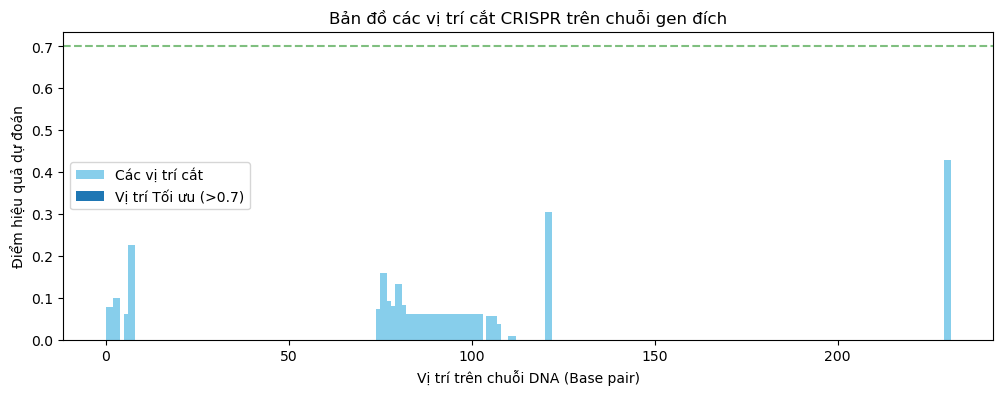

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# ==============================================================================
# 1. HÀM QUÉT & CẮT CHUỖI (SCANNING ALGORITHM) - Ý tưởng của bạn
# ==============================================================================
def scan_and_predict(long_sequence, model):
    """
    Hàm này nhận vào 1 chuỗi DNA dài bất kỳ (không giới hạn).
    Nó trượt dọc chuỗi để tìm motif PAM (NGG).
    Tại mỗi vị trí PAM, nó cắt ngược lại 23 ký tự để tạo thành sgRNA.
    Sau đó đưa vào model để dự đoán hiệu quả.
    """
    print(f"🧬 Đang phân tích chuỗi dài {len(long_sequence)} bp...")

    long_sequence = long_sequence.upper().replace("\n", "").strip() # Làm sạch
    candidates = [] # Chứa các đoạn 23bp
    positions = []  # Chứa vị trí cắt

    # --- QUÉT (SCANNING) ---
    # Duyệt từ đầu đến cuối chuỗi
    for i in range(len(long_sequence) - 1):
        # Kiểm tra điều kiện PAM: 2 ký tự liên tiếp là 'GG'
        if long_sequence[i] == 'G' and long_sequence[i+1] == 'G':
            # Vị trí PAM kết thúc tại i+2
            pam_end = i + 2
            # Vị trí bắt đầu của sgRNA (lùi lại 23 ký tự)
            start = pam_end - 23

            # Chỉ lấy nếu đủ độ dài (không bị index âm)
            if start >= 0:
                seq_23bp = long_sequence[start:pam_end]

                # Kiểm tra lại: chỉ chứa A,C,G,T (không lấy ký tự lạ)
                if all(c in 'ACGT' for c in seq_23bp):
                    candidates.append(seq_23bp)
                    positions.append(start)

    if len(candidates) == 0:
        return None, None

    print(f"-> Tìm thấy {len(candidates)} vị trí tiềm năng (có PAM).")

    # --- MÃ HÓA (ONE-HOT) ---
    # Tái sử dụng hàm mã hóa của bạn hoặc viết nhanh tại đây
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1]}
    encoded_batch = []
    for seq in candidates:
        vec = [mapping.get(base, [0,0,0,0]) for base in seq]
        encoded_batch.append(vec)
    X_scan = np.array(encoded_batch)

    # --- DỰ ĐOÁN (PREDICT) ---
    scores = model.predict(X_scan, verbose=0).flatten()

    # Tạo DataFrame kết quả
    results = pd.DataFrame({
        'Position': positions,
        'Sequence (23bp)': candidates,
        'Efficiency': scores
    })

    return results

# ==============================================================================
# 2. CHẠY THỬ NGHIỆM VỚI CHUỖI GEN DÀI VÔ TẬN
# ==============================================================================

# Load model đã train ở trên
try:
    final_model = load_model('best_model.keras')
except:
    print("❌ Chưa có model. Hãy chạy phần Training ở trên trước!")
    final_model = None

if final_model:
    # --- VÍ DỤ: Một đoạn dài của Gen TP53 (hoặc bạn paste cả nghìn ký tự vào đây) ---
    long_gene_input = """
    TTCCCTGGATTGGGTGGGGGCTGGGGAGGGAGAGTCGTTGCCGCCCATCAACAGAAACCCGACCGTAGCCC
    GGCGGGCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGGGGCTGGAGAGTGTTGGTC
    TGATAGTGACTTCATCTGGATCGCTTTAGACCTCTCGTTAAGTTCAACTGCAGCTCCCTGTATGTGATTTC
    ATCGTGGCAGGTGCCTCAGAGCGAGAGGAGAGAGAGAGAGAGAGAGAGAGAGAGACAGACAGATACAGAGA
    GGAGACGGACAGACAGCGGACAGACAGCGAGAGAGACAGAGACAGCGAGACAGAGACAGAGCGACAGAGAC
    """

    # Gọi hàm xử lý
    df_results = scan_and_predict(long_gene_input, final_model)

    if df_results is not None:
        # Sắp xếp để tìm ra vị trí tốt nhất
        top_targets = df_results.sort_values(by='Efficiency', ascending=False).head(10)

        print("\n🏆 TOP 10 VỊ TRÍ CẮT TỐT NHẤT:")
        print("-" * 85)
        print(f"{'Vị trí':<8} | {'Sequence (Spacer + PAM)':<30} | {'Score':<8} | {'Đánh giá'}")
        print("-" * 85)

        for _, row in top_targets.iterrows():
            seq = row['Sequence (23bp)']
            score = row['Efficiency']
            pos = row['Position']

            # Đánh giá nhanh
            rank = "🌟 Rất tốt" if score > 0.7 else ("✅ Khá" if score > 0.5 else "⚠️ Trung bình")

            print(f"{pos:<8} | {seq:<30} | {score:.4f}   | {rank}")

        print("-" * 85)

        # Vẽ biểu đồ trực quan hóa vị trí cắt trên gen
        plt.figure(figsize=(12, 4))
        plt.bar(df_results['Position'], df_results['Efficiency'], color='skyblue', width=2, label='Các vị trí cắt')
        # Tô đỏ những điểm > 0.7
        high_eff = df_results[df_results['Efficiency'] > 0.7]
        plt.bar(high_eff['Position'], high_eff['Efficiency'], color='red', width=2, label='Vị trí Tối ưu (>0.7)')

        plt.axhline(y=0.7, color='green', linestyle='--', alpha=0.5)
        plt.xlabel('Vị trí trên chuỗi DNA (Base pair)')
        plt.ylabel('Điểm hiệu quả dự đoán')
        plt.title('Bản đồ các vị trí cắt CRISPR trên chuỗi gen đích')
        plt.legend()
        plt.show()
    else:
        print("❌ Không tìm thấy vị trí cắt nào (không có PAM 'GG').")

# **5: XAI**

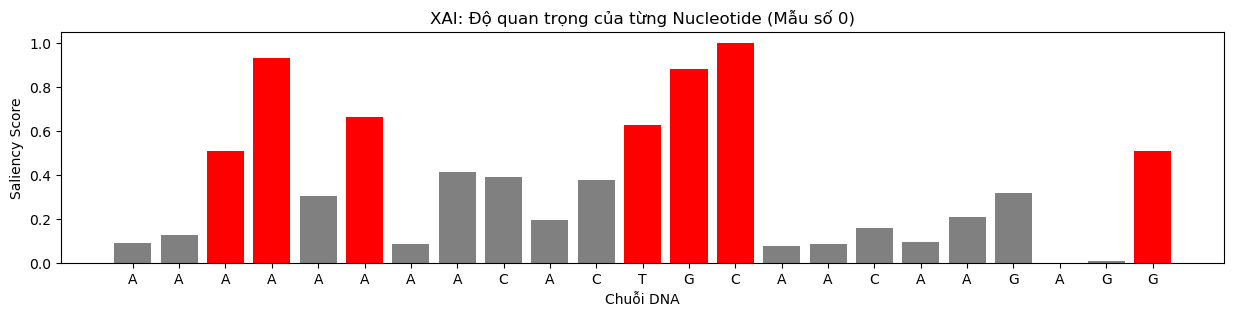

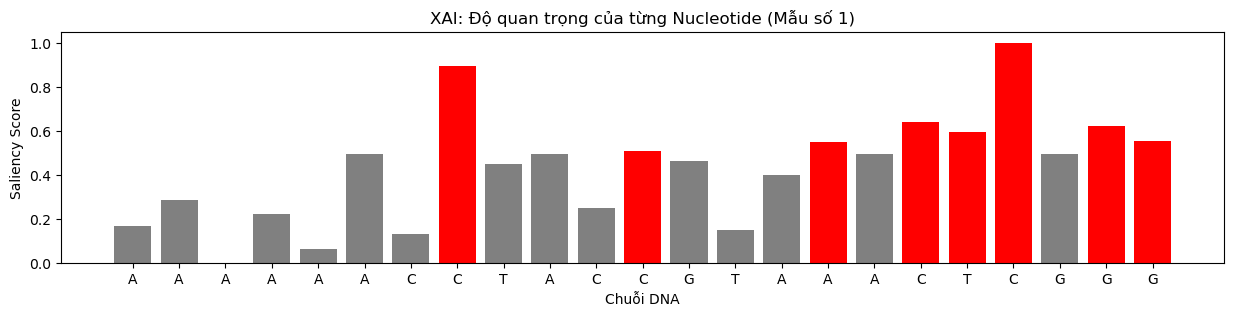

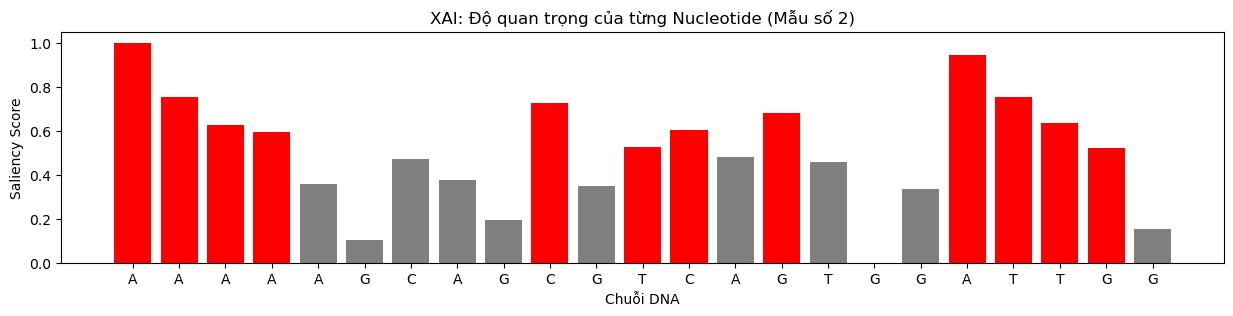

In [9]:
# ==============================================================================
# XAI: GRADIENT-BASED SALIENCY MAPS
# ==============================================================================
def get_saliency_map(model, x_input):
    """
    Tính toán độ quan trọng của từng nucleotide dựa trên Gradient.
    Saliency = d(Output) / d(Input)
    """
    x_input = tf.convert_to_tensor(x_input, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x_input)
        prediction = model(x_input)
    
    gradients = tape.gradient(prediction, x_input)
    # Lấy trị tuyệt đối của gradient và tổng hợp theo chiều One-hot
    saliency = tf.reduce_max(tf.abs(gradients), axis=-1).numpy()
    return saliency

def plot_xai_explanation(model, sequences_onehot, raw_sequences_list, index=0):
    sample_x = sequences_onehot[index:index+1]
    sample_raw = raw_sequences_list[index]
    
    saliency = get_saliency_map(model, sample_x)[0]
    
    # Chuẩn hóa về thang 0-1 để dễ nhìn
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-10)

    # Trực quan hóa
    plt.figure(figsize=(15, 3))
    colors = ['red' if s > 0.5 else 'gray' for s in saliency]
    plt.bar(range(23), saliency, color=colors)
    plt.xticks(range(23), list(sample_raw))
    plt.title(f'XAI: Độ quan trọng của từng Nucleotide (Mẫu số {index})')
    plt.ylabel('Saliency Score')
    plt.xlabel('Chuỗi DNA')
    plt.show()

# Giải thích cho 3 mẫu đầu tiên trong tập Test
for i in range(3):
    plot_xai_explanation(final_model, X_test, [raw_sequences[j] for j in range(len(X_test))], index=i)